# ECS7024 Statistics for Artificial Intelligence and Data Science


## Notebook 3: Aims and Outline

The overall aim of this notebook is to gain familiarity with correlations (in the broad sense of the influence of one variable on another) for both continuous and categorical variables. We first explore correlation, then cross tabulation and finally the distribution of continuous variables conditioned by a categorical one. 

The first section gives some details of the data. No depth of understanding of bridges is expected! 

 1. Section 1: Introducing the Data Set
     1. The Source of the Data and the Variables
     1. Loading the Data
     1. Initial Exploration
     
 1. Section 2: Correlation of Continuous Variables
     1. Correlation Matrix
     1. Scatter and other X-Y Plots
     1. The Scatter Matrix
 
 1. Section 3: Cross-tabulating Categorical Variables
     1. Cross Tabulation and Normalisation
     1. Plotting Conditional Probability Distributions
     1. Heat map of (Conditional) Probabilities
     
 1. Section 4: Distributions of Continuous Variables, by Category
     1. Using Box Plots to Compare the Distribution of one Variable by Another Variable
     1. Using Group By to Partition a Data Frame
     1. Reducing the Number of Categories
     1. Comparing Groups using Histograms and Kernel Density
   

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns   # this is an additional plotting library
%matplotlib inline

## Section 1: Introducing the Data Set

This notebook looks at some data from the US National Bridge Inspection maintained by the Federal Highways Agency (FHWA), part of the US Department of Transportation. The original data comes from the [National Bridge Inspection](https://www.fhwa.dot.gov/bridge/nbi/ascii.cfm) section of the FHWA's web site. However, it has been greatly simplified. If you are interested in a particular bridge, you can use the structure number to look it up (including on google maps, where the satellite imaging shows a picture) on the (Info Bridge System)[https://infobridge.fhwa.dot.gov/].

**The aim of the Bridge Inspection programme is to check on the state of bridges so that necessary repairs can be carried out. If this is not done, a bridge can fail. The dataset has information about the bridges and the condition given in the most recent inspection.**

* The FHWA's database covers the whole USA. Our data is only for the state of Texas. 
* As well as bridges, the FHWA's database covers tunnels (there seem to be no highway tunnels in Texas) and 'culverts'. A culvert is a form of drain, allowing water to pass under a highway. The culverts have been removed, leaving only the bridges.
* All of the bridges carry a highway (that is, a road runs over the bridge). What is underneath varies: another road, a waterway or a railway are among the possibilities. 

### Section 1.1 The Variables
The original FHWA dataset has over 100 variables (Texas collects even more); ours is simplified. Both continuous and categorical variables are included. 


| Variable      |      Description             | Type | 
|:--------------|:-----------------------------|:------:|
|Structure_id   | Unique identifier of the bridge                  | String |
|District       | Highway district in Texas responsible for bridge | category | 
|Detour_Km      | Length of detour if bridge closed                | continuous |
|Toll           | Whether a toll is paid to use bridge             | category |
|Maintainer     | The authority responsible for maintenance        | category |
|Urban          | Whether the bridge is located in an urban or rural area   | category |
|Status         | The road class: interstate to local                       | category | 
|Year           | The year the bridge was built                             | continuous | 
|Lanes_on       | The number of lanes that run over the bridge              | continuous (or discrete) |
|Lanes_under    | The number of lanes that run under the bridge             | continuous (or discrete) |
|AverageDaily   | The average daily traffic (number of vehicles)            | continuous |
|Future_traffic | The estimated daily traffic in approx 20 years time       | continuous |
|Trucks_percent | The percent of traffic made up of 'trucks' (i.e. lorries) | continuous |
|Historic       | Whether the bridge is historic                            | category | 
|Service_under  | The (most important) service that runs under the bridge   | category |
|Material       | The dominant material the bridge is made from             | category |
|Design         | The design of the bridge                                  | category |
|Spans          | The number of spans the bridge has                        | category (or discrete) |
|Length         | The length of the bridge in metres                        | continuous |
|Width          | The width of the bridge in metres                         | continuous |
|Rated_load     | The rated max loading of bridge (in tonnes)               | continuous |
|Scour_rating   | Only for bridges over water: the 'scour' condition        | ordinal |
|Deck_rating    | The condition of the deck of the bridge                   | ordinal |
|Superstr_rating| The condition of the bridge superstructure                | ordinal |
|Substr_rating  | The condition of the bridge substructure (foundations)    | ordinal |

**Note on 'scour'**: when a bridge is over (for example) a river, the flow of water in the river can undermine any bridge supports (called 'piers') in the water. This is called 'scouring' . The `Scour_rating` gives the condition with respect to possible damage from scouring. 
 
**Values of Categorical Variables** In the original data, the values of the categorical variables are represented as integers, with their meanings given in a data dictionary. In our dataset, these 'numeric codes' have been replaced with suitable names.

| Variable      |      Values            |
|:--------------|:-----------------------|
|District       | Each district has a unique number  |
|Toll           | Toll, Free                |
|Maintainer     | State, County, Town or City, Agency, Private, Railroad, Toll Authority, Military, Unknown |
|Urban          | Urban, Rural |
|Status         | Interstate, Arterial, Minor, Local |
|Historic       | Register, Possible, Unknown, Not historic |
|Service_under  | Other, Highway, Railroad, Pedestrian, Interchange, Building |
|Material       | Other, Concrete, Steel, Timber, Masonry |
|Design         | Other, Slab, Beam, Frame, Truss, Arch, Suspension, Movable, Tunnel, Culvert, Mixed |
|Scour_rating   | Unknown, Critical, Unstable, Stable, Protected, Dry, No waterway |
|Deck_rating    | *Rating*: NA, Excellent, Very Good, Good, Satisfactory, Fair, Poor, Serious, Critical, Failing, Failed |
|Superstr_rating| *Rating* |
|Substr_rating  | *Rating* |
    

### Section 1.2 Loading the Data

We can load the data from the CSV file. A 'type map' is used to set the types of each variables. Without this, Pandas guesses at the types, representing non-numeric fields as string. Instead, we represent them as Categorical Variables: using type `category` gives the default behaviour (use each unique value as a category and categories are not ordered). However, for the ordinal variables (categorical variables with an order) we must declare a suitable type explicitly.   

In [3]:
# The code below declares a catageorical type with categories in a specified order
# This can be used for an ordinal variable
rating_type = pd.CategoricalDtype(
    categories=['Failed', 'Failing', 'Critical', 'Serious', 'Poor', 'Fair', 
                'Satisfactory', 'Good', 'Very Good', 'Excellent', 'NA'], 
    ordered=True)

# This one is also for an ordinal variable, but with a slightly different set of values
scour_type = pd.CategoricalDtype(
    categories=['Unknown', 'Critical','Unstable', 'Stable', 'Protected', 'Dry', 'No waterway'], 
    ordered=True)

types_dict = { 'Structure_id': str, 'District':'category', 'Toll':'category', 
              'Maintainer':'category', 'Urban':'category', 'Status':'category', 
              'Historic':'category', 'Service_under':'category', 'Material':'category', 
              'Design':'category', 
              'Deck_rating':rating_type, 'Superstr_rating':rating_type, 'Substr_rating':rating_type, 
              'Scour_rating':scour_type}

bridges = pd.read_csv('tx19_bridges_sample.csv', dtype = types_dict, index_col = 'Structure_id')
bridges.dtypes
bridges # uncomment to preview the data

,District,Detour_Km,Toll,Maintainer,Urban,Status,Year,Lanes_on,Lanes_under,AverageDaily,...,Spans,Length,Width,Deck_rating,Superstr_rating,Substr_rating,Rated_load,Trucks_percent,Scour_rating,Future_traffic
Structure_id,,,,,,,,,,,,,,,,,,,,,
000021521-00101,District2,199,Free,Agency,Rural,Local,2005,1,0,1,...,2,31.4,4.3,Good,Very Good,Very Good,41.7,0.0,Dry,1
000021521-00181,District2,199,Free,Agency,Rural,Local,2005,1,0,1,...,1,15.5,4.3,Good,Good,Very Good,41.7,0.0,Dry,1
000021521-TMP20,District2,199,Free,Agency,Rural,Local,2012,2,0,100,...,1,10.1,8.4,Very Good,Very Good,Very Good,48.1,0.0,Dry,150
000021525-00012,District2,199,Free,Agency,Rural,Local,1950,1,0,80,...,14,45.4,3.7,Good,Good,Poor,10.0,0.0,Dry,120
000021580-00092,District2,6,Free,Agency,Rural,Local,2004,2,0,150,...,1,25.0,7.3,Good,Very Good,Very Good,37.2,4.0,Dry,200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DAPFORHOO000012,District9,0,Free,Military,Urban,Local,1994,3,0,300,...,3,45.4,19.0,Good,Good,Good,64.3,40.0,No waterway,600
DAPFORHOO000013,District9,0,Free,Military,Urban,Local,2000,2,0,300,...,1,12.3,10.8,Good,Good,Good,35.1,40.0,No waterway,600
DAPFORHOO000015,District9,0,Free,Military,Urban,Minor,1996,2,7,1200,...,4,73.2,9.8,Good,Good,Good,24.5,25.0,No waterway,1500


#### Exercise 1.1
Uncomment and run the following to get information about the fields (as seen by Pandas). You should notice that two variables have *null* values. You can find these using the code:

    bridges.loc[(bridges.Deck_rating.isnull()) | (bridges.Superstr_rating.isnull()) ]

Since there are only a small number of null, we will ignore them for now.

In [4]:
bridges[bridges.Deck_rating.isnull() | bridges.Superstr_rating.isnull()]

,District,Detour_Km,Toll,Maintainer,Urban,Status,Year,Lanes_on,Lanes_under,AverageDaily,...,Spans,Length,Width,Deck_rating,Superstr_rating,Substr_rating,Rated_load,Trucks_percent,Scour_rating,Future_traffic
Structure_id,,,,,,,,,,,,,,,,,,,,,
010920004518118,District1,0,Free,State,Rural,Arterial,1970,2,2,7520,...,1,42.7,12.2,NaN,Good,Good,32.7,2.0,No waterway,10530
021200AA0205001,District2,11,Free,County,Rural,Local,1946,1,0,340,...,1,17.7,3.9,Good,NaN,Fair,11.8,0.0,Stable,390
031690AA0273001,District3,5,Free,County,Rural,Local,2008,2,0,20,...,1,12.2,7.2,NaN,Very Good,Very Good,32.7,0.0,Dry,40
121020B37610001,District12,2,Free,Town or City,Urban,Local,2008,2,0,100,...,1,15.2,8.2,NaN,Good,Good,32.7,0.0,Stable,150
131580AA0323001,District13,159,Free,County,Rural,Local,1999,1,0,60,...,1,8.5,6.0,NaN,Very Good,Good,32.7,0.0,Dry,100
190190102001006,District19,10,Free,State,Rural,Minor,1991,2,0,160,...,4,67.1,9.1,NaN,Good,Good,32.7,16.0,Dry,230
211090AA0348002,District21,6,Free,County,Rural,Local,1960,2,0,50,...,3,11.0,5.5,Failing,NaN,Poor,0.0,0.0,Stable,30


### Section 1.3: Initial Data Exploration
This section recaps techniques from notebook 2. Do not spend too long on this at first but do look at distributions later if you need to. 

#### Exercise 1.2
Answer the following questions about the distribution of the number of bridges in each **district**.

1. Generate a pivot table giving the number of bridges in each district. (Hint: use `aggfunc='count'`. You need to specify a variable `values=` but any variable will do as we are only counting. See the effect of having leaving out `values=`.)
2. Does this distribution have a max, a min, a mean and a standard deviation? Find these out.
3. Show the distribution of the number of bridges in each district both as a bar chart and as a histogram.

Note that the data is collected by the [Texas Department of Transportation](https://www.txdot.gov/content/txdot/en.html) which is organised into [districts](https://www.txdot.gov/inside-txdot/district.html). I have not been able (or very concerned) to match up the district numbers with their names. 

#### Exercise 1.3
Also examine the distribution of other categorical variables, including at least one of the 'ratings'. Are some Texas bridges in a poor state?

In [5]:
bridges1 = bridges.copy()
bridges1_count = bridges1.groupby('District')['Maintainer'].count()
bridges1_count = bridges1_count.sort_values()
bridges1_count

bridges1_pivot = bridges1.pivot_table(values='Maintainer', index='District', aggfunc='count')
bridges1_pivot


,Maintainer
District,
District0,8
District1,1624
District10,1139
District11,997
District12,5099
District13,1752
District14,2126
District15,2152
District16,1024


#### Exercise 1.4
Also look at the distribution of the continuous variables. Below we show a quick way to do this; the following sections discuss some issues.

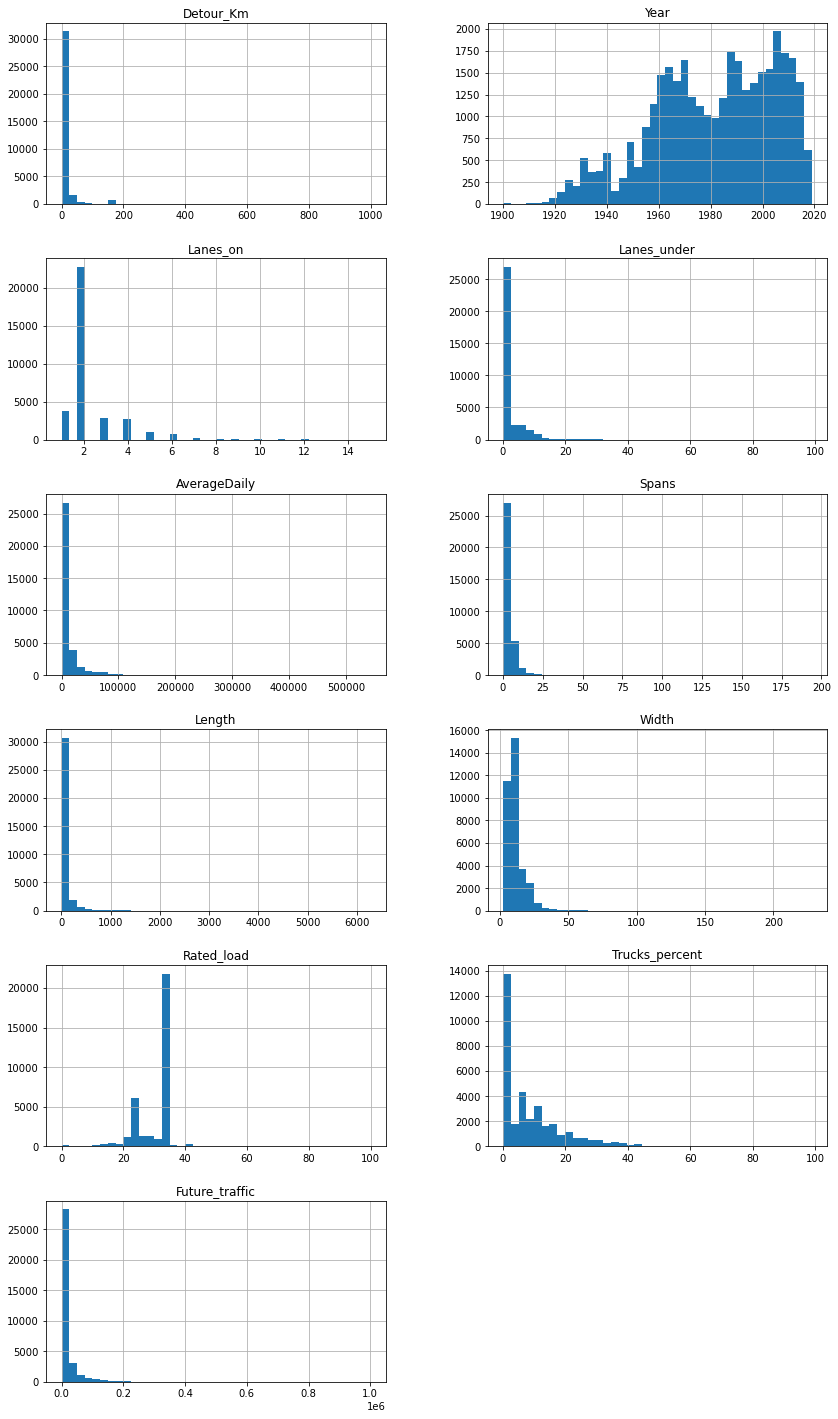

In [6]:
# The hist method ignores categorical variables, so we can just apply to to everything
_ax = bridges.hist(bins=40, figsize=(14,25), layout=(6,2)) # all the columns

#### Exercise 1.4 (Continued)

1. Are any of the data variables normally distributed? Is skew present?
2. Why are so many of the distributions shown almost all on the left side?

#### Exercise 1.5 Discrete (Numeric) versus Continuous

Earlier in the module, we introduced the distinction between categorical and continuous variable. This dataset has what are often called *discrete* variable. The following table summarises these distinctions.

| Type of Variable | Description |
|:-----------|:------------------------|
| Categorical | The values are categories: they can neither be added nor ordered. Example: apple, pear, banana|
| Ordinal     | The values are categories with an order; they cannot be added. Example: course rating: good, ok, bad |
| Continuous  | The values are numbers from an *infinite* set of possible values. Example: length |
| Discrete    | The values are whole numbers, from a finite (and not too large) set of possible values. Example: number of children in a family | 

Since discrete variables are numbers we can choose to treat them as continuous if we wish, depending on what we consider to a large set (there is reported to be a family with 21 children in the UK). Since the values can be added (as they are numbers) it would be unusual to use a categorical type for them in Pandas. 

It may be better to plot these variables using bar charts. Uncomment and run the code below. Then answer the questions that follow. Note that we use a log on the vertical axis. Try it without this.

<AxesSubplot:xlabel='Spans'>

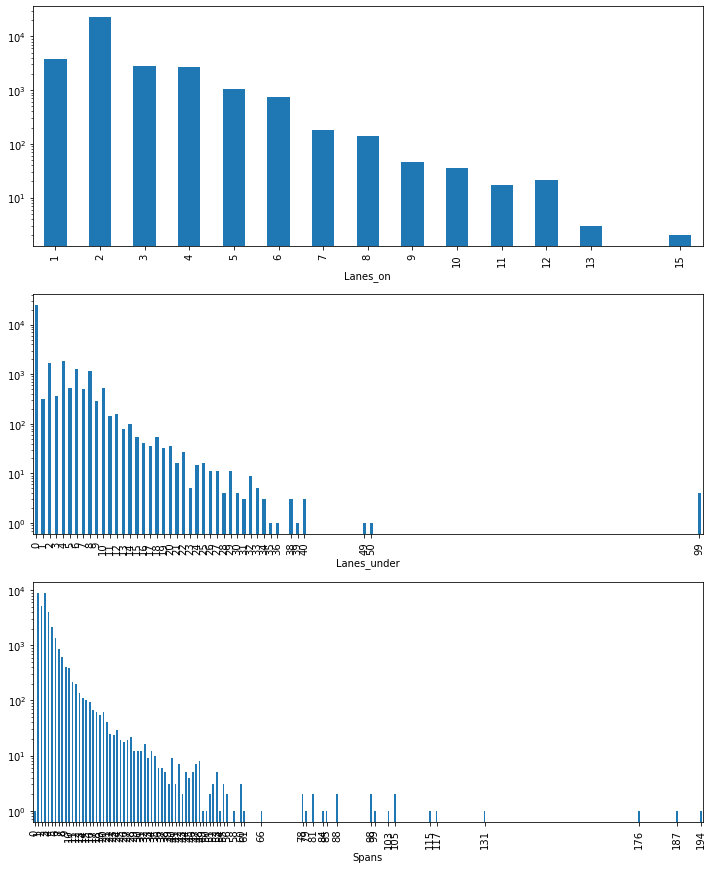

In [7]:
fig, (a1, a2, a3) = plt.subplots(3, 1, figsize = (12, 15))

bridges.pivot_table(values='Year', index='Lanes_on', aggfunc='count').plot(
    ax=a1, kind='bar', logy=True, legend=False)
bridges.pivot_table(values='Year', index='Lanes_under', aggfunc='count').plot(
    ax=a2, kind='bar', logy=True, legend=False)
bridges.pivot_table(values='Year', index='Spans', aggfunc='count').plot(
    ax=a3, kind='bar', logy=True, legend=False)

In [8]:
bridges.Service_under

Structure_id
000021521-00101     Highway
000021521-00181     Highway
000021521-TMP20     Highway
000021525-00012     Highway
000021580-00092     Highway
                     ...   
DAPFORHOO000012    Railroad
DAPFORHOO000013    Railroad
DAPFORHOO000015     Highway
DAPFORHOO00005A     Highway
DAPTRABLI000011    Railroad
Name: Service_under, Length: 34293, dtype: category
Categories (6, object): ['Building', 'Highway', 'Interchange', 'Other', 'Pedestrian', 'Railroad']

#### Exercise 1.5 (Continued)

1. It is strange that the most popular number of lanes under a bridge is zero. The are several explanations for this and the full picture is not available from the data included here. There is a variable `service_under` that shows that some bridges run over buildings - look at this. Another explanation is that the road of interest runs under the bridge so that the 'under' number refers to what is on the bridge. This needs more examination as this data has been excluded!
2. Sometimes a number is used when the true value is unknown. Can you see a probable example of this in any of these variables. We need to ask a highways engineer from Texas (or consult a data dictionary) to be sure. 
3. Can you see any values that are hard to believe?

In general, we need to check data for errors (often presenting as *outliers*). We will not do more of this now.

#### Exercise 1.6 
Now that we have looked at the discrete variable separately, rerun the histogram plot without the discrete variables. Hint: use the `column` parameter to select the variables you want to include. Also try `log=True`. Interestly, this parameter is not described in Pandas, but it is the matplotlib documentation. 

1. Do you see some more values that could be errors?

array([[<AxesSubplot:title={'center':'Length'}>,
        <AxesSubplot:title={'center':'Rated_load'}>],
       [<AxesSubplot:title={'center':'Future_traffic'}>, <AxesSubplot:>]],
      dtype=object)

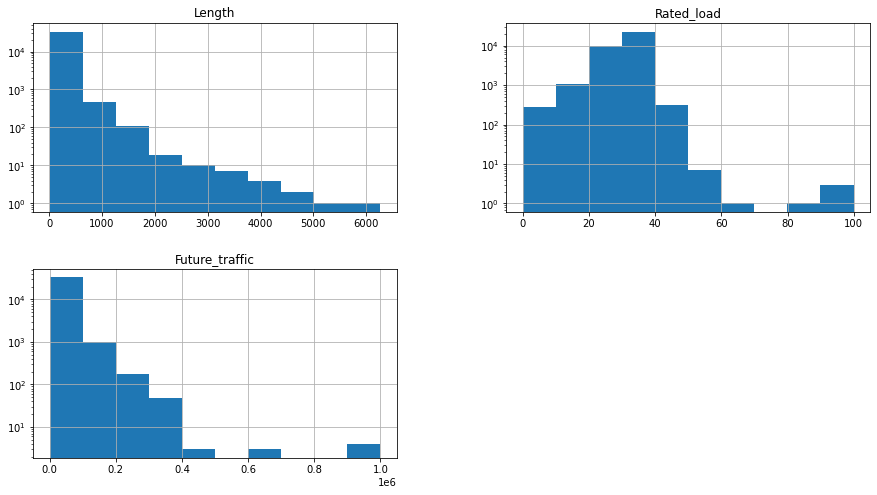

In [9]:
bridges.hist(column=['Length', 'Rated_load', 'Future_traffic'], log=True, figsize=(15,8))

## Section 2: Correlation of Continuous Variables
This section focuses just on the continuous variables. The concept of *correlation* is that two variables change together: as one doe sup so does the other (positive correlation) or as one goes up the other goes down (negative). 

### Section 2.1: The Correlation Matrix
The correlation coefficient between the continuous variables in the data frame can be calculated using `.corr()`. Conventionally, the categorical variables are just ignored.


In [10]:
bridges.corr()

,Detour_Km,Year,Lanes_on,Lanes_under,AverageDaily,Spans,Length,Width,Rated_load,Trucks_percent,Future_traffic
Detour_Km,1.000000,-0.024513,-0.111038,-0.150131,-0.136661,0.021051,-0.025573,-0.129509,-0.074833,0.007965,-0.133701
Year,-0.024513,1.000000,0.064312,0.151885,0.057762,-0.075133,0.115817,0.092663,0.366931,-0.215144,0.068084
Lanes_on,-0.111038,0.064312,1.000000,0.237121,0.569665,0.034389,0.053918,0.842755,0.196427,-0.009249,0.543820
Lanes_under,-0.150131,0.151885,0.237121,1.000000,0.366752,0.166926,0.480803,0.300220,0.203972,-0.011792,0.368653
AverageDaily,-0.136661,0.057762,0.569665,0.366752,1.000000,0.076196,0.168745,0.587129,0.194222,0.023467,0.914798
Spans,0.021051,-0.075133,0.034389,0.166926,0.076196,1.000000,0.609742,0.080100,0.087519,0.125985,0.078115
Length,-0.025573,0.115817,0.053918,0.480803,0.168745,0.609742,1.000000,0.123974,0.149799,0.046890,0.171969
Width,-0.129509,0.092663,0.842755,0.300220,0.587129,0.080100,0.123974,1.000000,0.286784,0.139993,0.568987
Rated_load,-0.074833,0.366931,0.196427,0.203972,0.194222,0.087519,0.149799,0.286784,1.000000,0.179288,0.191833
Trucks_percent,0.007965,-0.215144,-0.009249,-0.011792,0.023467,0.125985,0.046890,0.139993,0.179288,1.000000,0.023660


**Heat Map** The correlation is often shown as heat map. The best one (*that I have found so far*) is from the [Seaborn library](https://seaborn.pydata.org/) (`sns`). This is another library for visualisation, also built on matplotlib.

Uncomment the code below to see the heat map. 

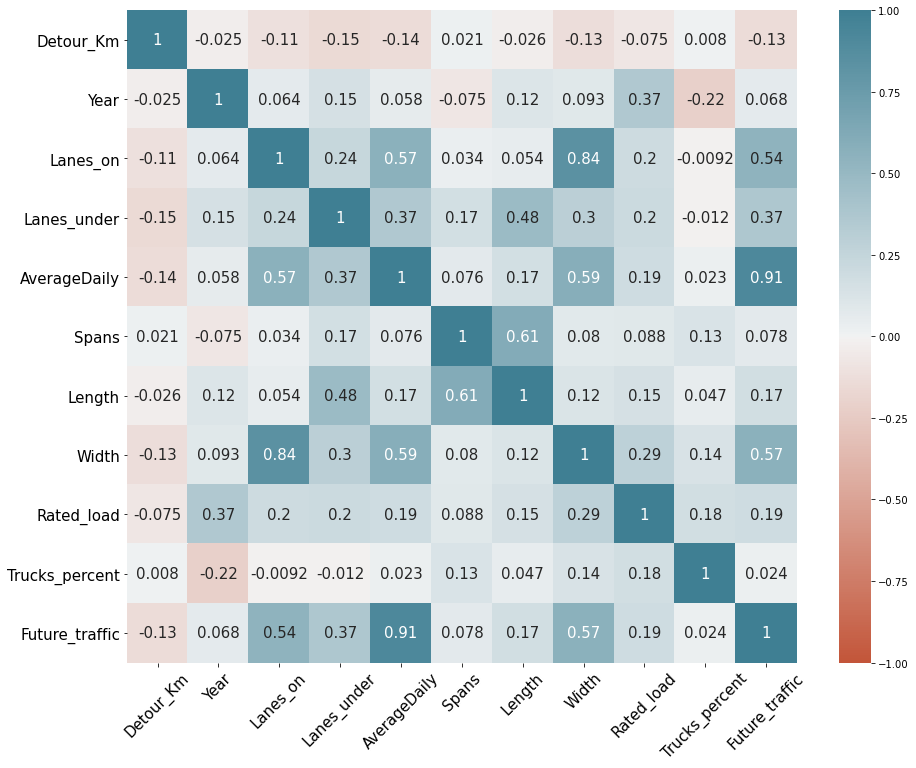

In [11]:
fig,ax = plt.subplots(1,1, figsize=(15,12))
sns.heatmap(bridges.corr(), vmin=-1, vmax=1, cmap=sns.diverging_palette(20, 220, as_cmap=True), 
            annot=True, ax=ax, annot_kws={"size": 15})
_y = plt.yticks(rotation=0, fontsize=15)
_x = plt.xticks(rotation=45, fontsize=15)

#### Exercise 2.1
Inspect the correlation heat map. Can the larger correlations be explained? 

### Section 2.2: Scatter and other X-Y Plots

This section shows how we can construct a scatter plot. 

The following example shows how to use the `'scatter'` plot kind. Given that we have over 30,000 bridges, what do you expect to see? Uncomment this and run it: are your fears confirmed? Do you see the problem? See also the influence that the outlier values have on the plot.

Note that we have chosen two values to show on these plots: this is just for illustration.      

<AxesSubplot:xlabel='Year', ylabel='AverageDaily'>

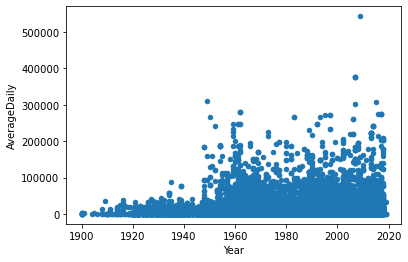

In [33]:
bridges.plot(kind='scatter',  x='Year', y='AverageDaily')

**Problem 1: Skew and Outliers**

The scatter plot is difficult to interpret because the data is very skewed and has outliers.
1. We can show log of the value on either axis (or both). Note that this makes any relationship harder to interpret.
2. We can filter out more extreme values. This spreads the points out as they are more evenly distributed over the range.

#### Exercise 2.2 Dealing with Outliers and Skew
The code below shows both of these techniques. Try this and try them separately as well.

<AxesSubplot:xlabel='Width', ylabel='AverageDaily'>

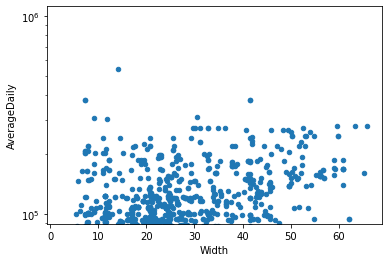

In [39]:
bridges.loc[bridges.Width < 75].plot(kind='scatter',  x='Width', y='AverageDaily',logy = True)

**Problem 2: Very Dense Scatter Plots**

We suggest three possible solutions to the problem of having so many points to show on a scatter.

1. Make the dots transparent: used `alpha=0.1` where `0.1` makes the points 90% transparent allowing you to see several dots at or near the same point.

2. Plot only a sample of the data points. 

3. Use a different kind of X-Y plot, using hexagonal binning.

#### Exercise 2.3 Plotting Very Dense Scatter Plots using Transparency
Redo the scatter using alpha of less than 1. Is this an adequate way to show this number of data points?


<AxesSubplot:xlabel='Width', ylabel='AverageDaily'>

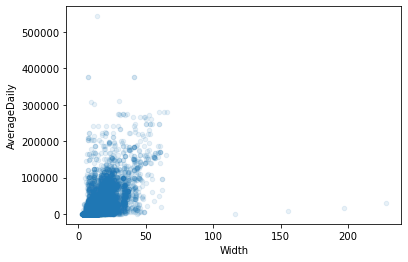

In [41]:
bridges.plot(kind='scatter', x='Width', y='AverageDaily', alpha=0.1)

#### Exercise 2.4 Plotting Very Dense Scatter Plots using a Sample of Data

We can select a sample of the data and plot just this sample. When there is lots of data, we should still see any relationship (except for outliers). Use `bridges.sample(frac=0.01).plot(...` to select 1% of the bridge data.

<AxesSubplot:xlabel='Width', ylabel='AverageDaily'>

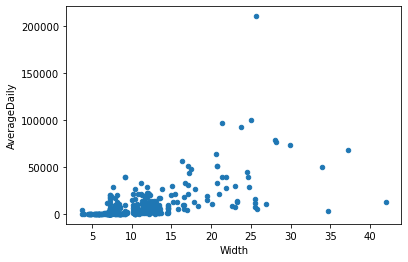

In [43]:
bridges.sample(frac=0.01).plot(kind='scatter',x='Width', y='AverageDaily')

#### Exercise 2.5 Plotting Very Dense Scatter Plots use Hex Bins

The code below shows how we can plot 'hex' bins, to give a form of two dimensional density. There is no need to sample the data. However, we have limited the range - see the effect of removing this. These plots are also tuned by choosing the size of the hexagons (using the `gridsize` parameter).  

You should see two dense regions (the 2-dimensional analog of bi-modal) in this plot. Can you form a hypothesis of why this might be?

<AxesSubplot:xlabel='Year', ylabel='Length'>

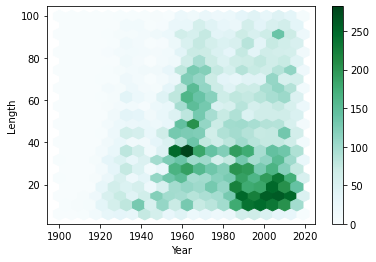

In [44]:
bridges.loc[bridges.Length < 100].plot(kind='hexbin',  x='Year', y='Length',  gridsize=20, sharex=False)
   # It is not completely clear why sharex=False is needed but without the x axis disappears. This may be a bug.

### Section 2.3: The Scatter Matrix

Pandas provides a function to plot 'scatter matrix', which shows a scatter plot of all the numeric variables (with distributions on the diagonal axis; kde are available as well). 

Uncomment the next line - wait a while - and see that 11 x 11 is not so useful. 

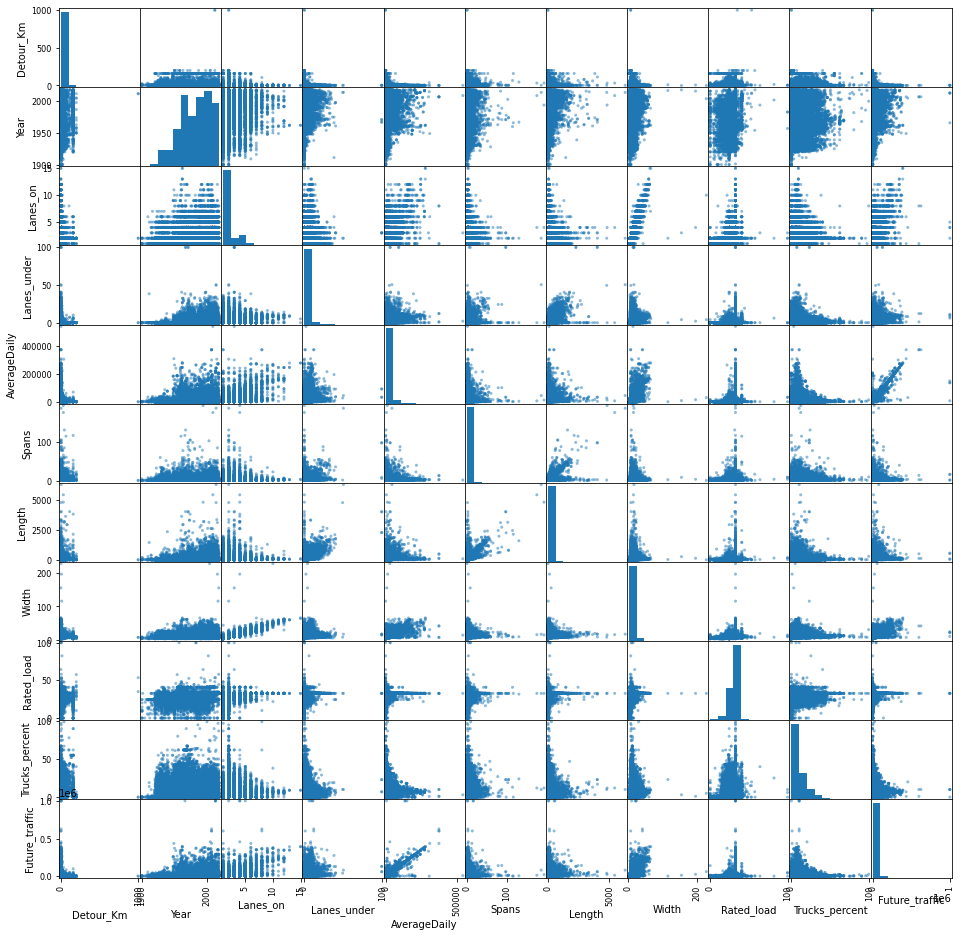

In [45]:
_a = pd.plotting.scatter_matrix(bridges, figsize=(16,16))

# The variable on the left hand side _a is useful as otherwise the return value (121 axes) is displayed. 
# We assign it to a variable to stop this happening. Starting the name with an underscore is a convention
# for saying 'dummy variable' 

#### Exercise 2.6 Categorising the Variables

One way to proceed is to group the 11 variables by what they relate to. There are many ways to do this; we have chosen to have a group that are about the way the bridge is used and another about its physical structure. 

The code below select some variables as relating to use and then filters extreme values. Review this data frame and then plot a scatter matrix using a 25% sample and some transparency.  

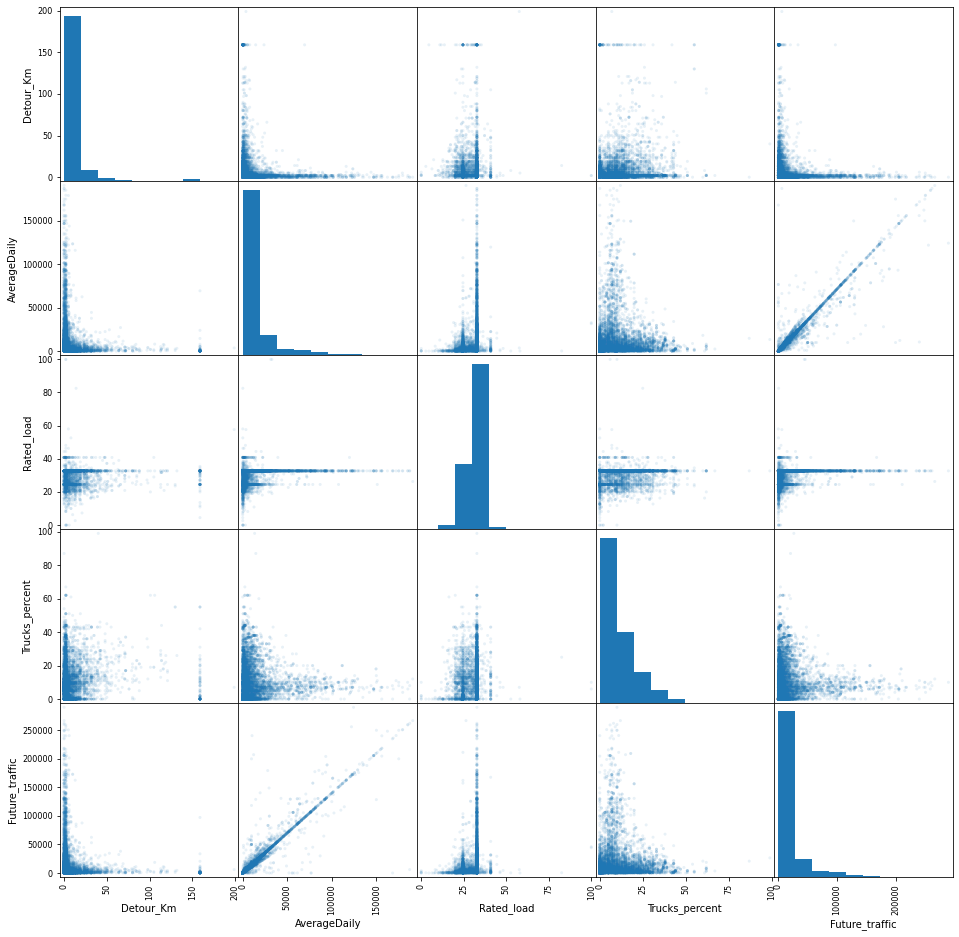

In [48]:
use_vs = ['Detour_Km', 'AverageDaily', 'Rated_load', 'Trucks_percent', 'Future_traffic']
use_b = bridges.loc[(bridges.Detour_Km < 200) & (bridges.AverageDaily > 100) & 
                    (bridges.AverageDaily < 200000) & (bridges.Future_traffic < 300000), use_vs]
#use_b

_b = pd.plotting.scatter_matrix(use_b.sample(frac=(0.25)), figsize=(16,16), alpha=0.1)

#### Exercise 2.7
Also plot the scatter matrix for the other group of variables. They are listed below.

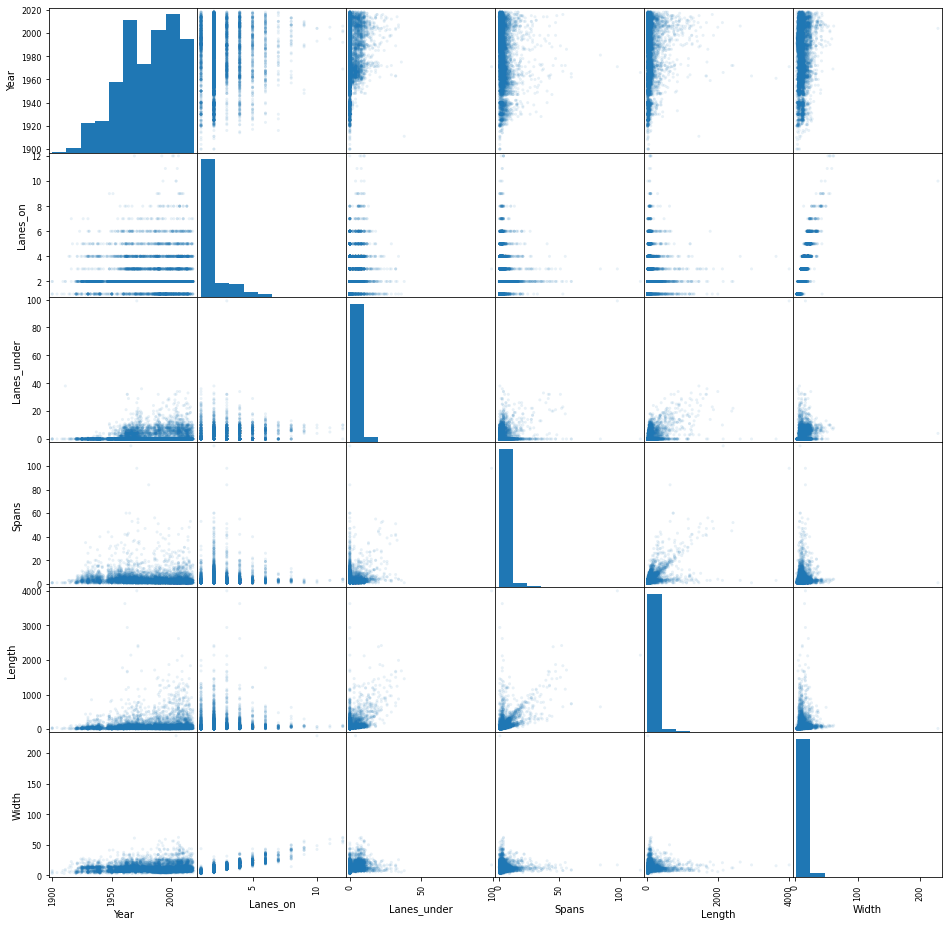

In [54]:
str_vs = ['Year', 'Lanes_on', 'Lanes_under', 'Spans', 'Length', 'Width']
str_b = bridges[['Year', 'Lanes_on', 'Lanes_under', 'Spans', 'Length', 'Width']]
str_b

_strb = pd.plotting.scatter_matrix(str_b.sample(frac=(0.25)),alpha=0.1, figsize=(16,16))

#### Exercise 2.8 (*Very Optional*)
In some ways, it would be more useful to have scatter plots for each pair of variables, one from the list relating to use and the other from the list relating to the structure. Work out how to do this in something like a matrix.

## Section 3: Cross-tabulating Categorical Variables
This section looks at the categorical variables. We first use `crosstab` to cross tabulate variables in a table (also called a contingency table). We then consider how to show conditional probability distributions using bar charts before also using a `heatmap` to display conditional probabilities. 

### Section 3.1 Cross Tabulation and Normalisation

The following code looks at the relationship between two categorical variables, using cross tabulation which is similar to pivot. We can use the `crosstab` function in the following ways:

* We can normalise over all values creates a joint probability distribution. We can add totals to this, which show the marginal probability distribution of the two variables.
* We can normalise over the index. This makes all the rows sum to 1, giving probability of the variable on the x-axis, given the variable on the y-axis.
* To get the other conditional probability, we swap the parameters but still normalise the index. This seems better for plotting.
* Totals are not useful when normalising. If you include `margins=True` only the total on the unnormalised axis are given and they are not of interest.
* It is convenient to display the table as percentages. See how this is done.
* We do not want either totals or percentages for plotting.

**Note** The variables `deck_and_mat`, `mat_and_deck`, `deck_given_mat` and `mat_given_deck` and used later, so do not overwrite them.

In [18]:
# Joint probabilities - normalise all
#  The first parameter is the index (it can be a list)
#  The second parameter is the columns (it can be a list)
deck_and_mat = pd.crosstab(bridges.Deck_rating, [bridges.Material], normalize='all')
deck_and_mat_tot = pd.crosstab(bridges.Deck_rating, [bridges.Material], normalize='all', margins=True)
mat_and_deck = pd.crosstab(bridges.Material, [bridges.Deck_rating], normalize='all')

# Conditional probabilities - normalise index
#   The first parameter is the index: since we normalise this become sthe conditioning variable
#   The second parameter is the columns: the variable(s) whose prob dist is give for each conditioning value
mat_given_deck = pd.crosstab(bridges.Deck_rating, [bridges.Material], normalize='index')
deck_given_mat = pd.crosstab(bridges.Material, [bridges.Deck_rating], normalize='index')

# Uncomment one of the variables (also used in next section) to see the table
# --------------------------------------------------------------------------
#deck_and_mat_tot.round(4) * 100
#mat_and_deck.round(4) * 100
#mat_given_deck.round(4) * 100
deck_given_mat.round(4) * 100



Deck_rating,Failed,Failing,Critical,Serious,Poor,Fair,Satisfactory,Good,Very Good,Excellent
Material,,,,,,,,,,
Concrete,0.00,0.01,0.00,0.00,0.10,2.08,19.22,64.68,13.19,0.72
Masonry,0.00,0.00,0.00,0.00,0.00,0.00,7.69,15.38,76.92,0.00
Other,0.00,0.00,0.00,0.00,0.00,4.17,22.92,35.42,33.33,4.17
Steel,0.09,0.03,0.02,0.02,0.74,9.11,32.78,49.23,7.71,0.27
Timber,1.08,0.22,0.00,0.00,1.51,15.70,40.22,37.63,3.66,0.00


**Note about Crosstab and NaN** If you have missing data represented by NaN then `pd.crosstab` just ignores it. You can replace `NaN` values using `fillna`. This is not much concern with this dataset, so we do not examine this in more detail. 

#### Exercise 3.1
Look at each of the cross tabulation tables created above. Find the right table to answer the following questions.

> 
> 1. What percentage of failing bridges are concrete?
> 2. What percentage of steel bridges are in 'poor' or worse condition?
> 3. Are there more bridges that are in good condition and made of concrete or in satisfactory condition and made of steel?

#### Exercise 3.2

1. Construct cross tabulations for other pairs of categorical variables. 
3. You can also use discrete variables (if there are not too many values) 


#### Exercise 3.3
Try some variations of cross tabulation
1. Above we have made the variable being conditioned on (i.e. B in p(A|B)) the index and then normalised so that the rows add to one (or 100%). Is it easier to read a conditional probability table if the columns sum to 1? Try this. For `normalize=` you can put `'all’`, `‘index’`, `‘columns’` or `False`.
1. Try cross tabulation without normalisation: this gives counts.
1. Try cross tabulation with 3 (or more) variables. It is easier (in your view) to have 2 variables in the index (more rows) or in the columns?

### Section 3.2 Plotting Probability Distributions

The code below shows how to plot using bar charts. By default, the x-axis shows the index variable(s). The x axis seems most appropriate for the variable being conditioned on (i.e. B in p(A|B)). The joint distribution can be shown either way around, with no obvious way to prefer one from the other. We have shown one plot as stacked, for illustration.

#### Exercise 3.4 

1. Uncomment and run the code below
2. Experiment with `stacked=True` and `stacked=False`. Which do you prefer? 
1. Also plot other cross tabulations, including one with three variables.

In [19]:
# Generate suitable axes
#fig,(a1, a2, a3, a4) = plt.subplots(4,1,figsize=(15,20), sharey=False, sharex=False)
#fig.subplots_adjust(hspace=0.35)

# Plot one tabulation on each axis WITH CAREFUL TITLES
#deck_and_mat.plot(kind='bar', subplots=False, ax=a1, rot=0)
#a1.set_title('Joint Probability of Deck Rating and Main Material (plot 1)', fontsize=14)

#mat_and_deck.plot(kind='bar', subplots=False, ax=a2, rot=0)
#a2.set_title('Joint Probability of Main Material and Deck Rating (plot 2)', fontsize=14)

#mat_given_deck.plot(kind='bar', subplots=False, ax=a3, rot=0, stacked=True)
#a3.set_title('Probability of Materials, given Deck Rating', fontsize=14)

#deck_given_mat.plot(kind='bar', subplots=False, ax=a4, rot=0, stacked = False)
#a4.set_title('Probability of Deck Rating, given Material', fontsize=14)

#### Exercise 3.5
The code below displays a cross-tabulation using a pie chart. There is no normalisation. What is the chart actually showing?

In [20]:
#deck_and_mat = pd.crosstab(bridges.Deck_rating, [bridges.Material], normalize=False)
#(a1,a2),(a3,a4),(a5,_) = deck_and_mat.plot(kind='pie', subplots=True, figsize=(20,20), layout=(3,2), autopct='%.1f')

# remove ticks from x axis
#_ = [a.tick_params(axis='x', which='both', bottom=False) for a in [a1,a2,a3,a4,a5]]


### Section 3.3 Heatmap of (Conditional) Probabilities

In this section we use the the heatmap to display a cross-tabulation. The heatmap of the conditional probability gives an impression of the correlation but bear in mind that p(A|B) is not equal to p(B|A), which does not match our intuition for correlation. 

#### Exercise 3.6
1. Uncomment the code below and display the heatmap.
2. Try with normalise as `columns` or `False`, changing the the title appropriately.

In [21]:
#super_given_deck = pd.crosstab(bridges.Deck_rating, [bridges.Superstr_rating], normalize='index')

#fig,ax = plt.subplots(1,1, figsize=(12,10))
#sns.heatmap(super_given_deck.round(4)*100, cmap=sns.light_palette('grey'), linewidths = 2,
#            annot=True, ax=ax, annot_kws={"size": 13}, fmt='g')
#ax.set_title('Superstructure Rating given Deck Rating', fontsize=14)

## Section 4: Distributions of Continuous Variables, by Category

We are interested to understand how the continuous variables (such as year) are *correlated* (in the general sense) with categorical variables with one (or more) of the categorical variables. This is, we can ask how the distribution of the continuous variable (or its statistics) changes given the value of the category.

For example, we might be interested in the relationship between the year built and the material. We suspect that bridges are no longer built from masonry (i.e stone and brick). The problem is that the numbers in each category are different. One solution is to create separate data frames (or data frame views). However, Pandas provides two other convenient ways to do this.



### Section 4.1 Using Box Plots to Compare the Distribution of one Variable by Another Variable

Recall that a boxplot is really a visualisation of the summary statistics of a distribution. The `boxplot` can select a variable whose distribution is to be summarised (the `column=` argument) and a categorical variable (the `by=` argument) so that a separate summary is shown for each category.

There are some examples below.

In [22]:
#fig, (a1, a2, a3) = plt.subplots(3,1, figsize=(15,14))

#bridges.boxplot(column='Year', by='Material', ax=a1)
#bridges.boxplot(column='Year', by='Deck_rating', ax=a2)
#bridges.boxplot(column='Year', by='Design', ax=a3)

# Make the plots a bit clearer
#fig.suptitle('')
#[a.set_title('') for a in [a1, a2, a3]]
#a1.set_ylabel('Year')
#a2.set_ylabel('Year')
#a3.set_ylabel('Length (m)')


#### Exercise 4.1

1. Describe the relationship between year and the construction material
2. Draw a plot of the `AverageDaily` and the road `Status` and also of bridge `Length` and whether a `Toll` is paid. Can you explain why neither plot is very informative?

**Very Skewed Distributions** 

Although a boxplot is very robust, it does not handle very skewed distributions. Most bridges are short (not very heavily used) but some are very long (or very heavily used). 

#### Exercise 4.2 
The code below shows how we can create a data frame with extra columns with the logarithms of variables - such as those that have very skewed distributions. Plot these log values using a box plot. Is it easier to see if there is a relationship?

In [23]:
#brd_logs = bridges.assign(AverageDailyLog = np.log10(bridges.AverageDaily),
#                         LengthLog = np.log10(bridges.Length))

# Note that this code has a runtime warning: some of the values are zero, which has no logarithm. 


### Section 4.2 Using `groupby` to Partition a Data Frame

The `by=` parameter of the box plot is not generally available. Instead, we use the Pandas `groupby` method. The effect of this is to partition a data frame into a set of data frame, one for each value of a categorical variable.

#### Exercise 4.3 
The following code creates a group by using the`Deck_rating` category. Uncomments and access the .

In [24]:
gbyDeck = bridges.groupby(by = 'Deck_rating', dropna=False)

gbyDeck.get_group('Failed')

#gbyDeck.get_group('Failing')
#gbyDeck.get_group('Good')
#gbyDeck.get_group('Excellent')


,District,Detour_Km,Toll,Maintainer,Urban,Status,Year,Lanes_on,Lanes_under,AverageDaily,...,Spans,Length,Width,Deck_rating,Superstr_rating,Substr_rating,Rated_load,Trucks_percent,Scour_rating,Future_traffic
Structure_id,,,,,,,,,,,,,,,,,,,,,
010750AA0230001,District1,8,Free,County,Rural,Local,1971,1,0,10,...,1,13.1,4.9,Failed,Failed,Failed,0.0,0.0,Critical,40
010920AA0504001,District1,14,Free,County,Rural,Local,1975,1,0,60,...,2,7.0,3.7,Failed,Failed,Failed,0.0,0.0,Critical,135
052190AA0193007,District5,13,Free,County,Rural,Local,1935,1,0,50,...,1,15.2,4.8,Failed,Failed,Failed,0.0,0.0,Stable,40
061950AA0184001,District6,159,Free,County,Rural,Local,1936,1,0,1,...,3,15.9,3.7,Failed,Failed,Failed,0.0,0.0,Critical,1
082090AA0188001,District8,16,Free,County,Rural,Local,1900,1,0,1,...,1,94.8,4.1,Failed,Failed,Failed,0.0,0.0,Critical,1
090740AA0168001,District9,5,Free,County,Rural,Local,1950,1,0,50,...,2,13.7,4.9,Failed,Failed,Failed,0.0,0.0,Stable,75
090740AA0299001,District9,8,Free,County,Rural,Local,1996,1,0,100,...,4,18.3,5.8,Failed,Failed,Failed,0.0,0.0,Stable,70
090740AA0301001,District9,159,Free,County,Rural,Local,1991,1,0,55,...,3,14.9,5.6,Failed,Failed,Failed,0.0,0.0,Stable,50
091610AA0790001,District9,3,Free,County,Rural,Local,1999,2,0,70,...,3,25.9,7.2,Failed,Failed,Failed,0.0,0.0,Critical,100


#### Exercise 4.4
The follow code shows a way to look at the size of groups. Run the code. Do the same for some other categorical variables.

In [25]:
#gbyDeck.size().plot(kind='bar', logy=True)

#### Exercise 4.5
The following code uses `describe` on each of the groups in a `GroupBy` object (created using the `groupby` method). Run it and look at the result.

In [26]:
def describeBy(groups, columns):
    for (index,grp) in groups:
        print('\nGroup', index)
        print('------------------')
        print(grp.loc[:,columns].describe())

# describeBy(gbyDeck, ['AverageDaily', 'Year', 'Trucks_percent'])

### Section 4.3 Reducing the Number of Categories

We may need to reduce the number of categories when,as here, the sizes are very uneven. 

In [27]:
# define new ordinal type for the simplified rating
simp_rating_type = pd.CategoricalDtype(categories=['Fair_or_worse', 'Satisfactory', 'Good', 
                                                   'Very Good', 'Excellent'], ordered=True)
# create a dictionary mapping existing to new values
simp_d = {'Failed':'Fair_or_worse', 'Failing':'Fair_or_worse', 'Critical':'Fair_or_worse', 
          'Serious':'Fair_or_worse', 'Poor':'Fair_or_worse', 'Fair':'Fair_or_worse'}

# define a function we can apply to map the values
def simDRating(row):
    if row.Deck_rating in simp_d:
        return simp_d[row.Deck_rating]
    return row.Deck_rating
        

# apply the function, creating a new column,
nbgs = bridges.assign(SimpDeck = bridges.apply(simDRating, axis=1))
nbgs = nbgs.astype({'SimpDeck':simp_rating_type})
#nbgs

We can now use the new column in a group by. 

In [28]:
gbySDeck = nbgs.groupby(by = 'SimpDeck')
gbySDeck.size()

SimpDeck
Fair_or_worse     1347
Satisfactory      7588
Good             21006
Very Good         4132
Excellent          215
dtype: int64

### Section 4.4 Comparing Groups using Histograms and Kernel Density

Once we have created groups, these can be displayed using either histograms or kernel density estimators.

#### Exercise 4.6 Histogram of Groups
The histogram method can be applied directly to the 'group by' object. The default behaviour is to show a separate histogram for each group. 

1. Uncomment and run the code below. Note that the x-axes are different for each group (but using `sharex=True` does not work as we might hope).
2. Create histograms for other continuous variables or grouped by other categorical variables.

In [29]:
#axs = gbySDeck.hist(column=['Year', 'Rated_load'], alpha=0.3, bins=15, density=True, figsize=(14,4), legend=True)
      # The parameter log=True can be useful

# This sets the titles
#names = ['Fair_or_worse', 'Satisfactory', 'Good', 'Very Good', 'Excellent']
#_t = [axs[name][0][col].set_title('Deck rating is ' + name) for name in names for col in [0,1]]

Alternatively, we can create the axes first and then have the histograms for different group share the same axis. The disadvantage here is that the *excellent* group has a very skewed distribution. The only way (I know of) to remove this is to filter it out of the data frame before creating the groups.  

#### Exercise 4.7 

1. Uncomment and run the code below. Do you see why the group for bridges with an 'excellent' deck condition makes it harder to see the distributions? Outliers are also a problem.
2. Create histograms for other continuous variables or grouped by other categorical variables.

In [30]:
# Create the figure
#fig, axs = plt.subplots(2, 1, figsize=(14,10))

# plot the histogram using these axes
#_x = gbySDeck.hist(column=['Year', 'Rated_load'], ax = axs, alpha=0.3, bins=15, density=True) #, log=True)

# Set a legend, using the group names 
#name = ['Fair_or_worse', 'Satisfactory', 'Good', 'Very Good', 'Excellent']
#axs[0].legend(names)
#axs[1].legend(names)


**Plotting Kernel Density Estimation** A KDE can also be used to show the distribution. Although the Pandas library has a KDE plot type, the version from the Seaborn library is better. The code is slightly longer as we have to add each group separately. However, this has the advantage of flexibility. For example, we can omit the 'excellent' group. 

#### Exercise 4.8

1. Uncomment and run the code below.
2. To what extent and how do the ages of bridges with the different deck conditions differ? 

In [31]:
d_fair = gbySDeck.get_group('Fair_or_worse')
d_sat = gbySDeck.get_group('Satisfactory')
d_gd = gbySDeck.get_group('Good')
d_vg = gbySDeck.get_group('Very Good')
d_ex = gbySDeck.get_group('Excellent')

#fig, ax1 = plt.subplots(1, 1, figsize=(14,5))
var = 'Year'

#sns.kdeplot(data=d_fair[var], label='Fair', ax=ax1, alpha=0.3, shade=True)
#sns.kdeplot(data=d_sat[var], label='Satisfactory', ax=ax1, alpha=0.3, shade=True)
#sns.kdeplot(data=d_gd[var], label='Good', ax=ax1, alpha=0.3, shade=True)
#sns.kdeplot(data=d_vg[var], label='Very Good', ax=ax1, alpha=0.3, shade=True)
# omit this one #sns.kdeplot(data=d_ex['Year'], label='Excellent', ax=ax1, alpha=0.3, shade=True)

#ax1.set_xlabel(var)